In [104]:
import numpy as np
import cv2
from hdrtool import hdr
from hdrtool import align
import pandas as pd
import os
import importlib
import time
import matplotlib.pyplot as plt
import os

In [106]:
IMGDIR = './example/test6'
META = './example/test6.csv'
OUTPUT_PATH = os.path.basename(IMGDIR)+'-output.jpg'
OUTPUT_PATH2 = os.path.basename(IMGDIR)+'-output2.jpg'
HDR_PATH = os.path.basename(IMGDIR)+'output.hdr'

## Load Meta Data

In [107]:
df = pd.read_csv(META, sep='\s+')

In [108]:
if 'exposetime' not in df.columns:
    df['exposetime'] = 1/df['1/shutter_speed']

In [109]:
if len(df) > 8:
    mid = len(df)//2
    df = df[2:mid+2].reset_index()

In [110]:
df

Filename  exposetime
0    a.JPG        0.25
1    b.JPG        1.00
2    c.JPG        4.00
3    d.JPG       15.00

In [111]:
# read the images
imgs = [cv2.resize(cv2.imread(os.path.join(IMGDIR,fn)),(900, 1600)) for fn in df.Filename]

## Image alignment

In [113]:
image_alignment = align.ImageAlignment()

def solve_alignment(images, d=5):
    for i in range(1, len(images)):
        print('\r[Alignment] %d' % (i + 1), end='')
        images[i] = image_alignment.fit(images[i], images[i-1], d)
    print()
    return images

### This is opitonal
#imgs = solve_alignment(imgs)

## Plotting images

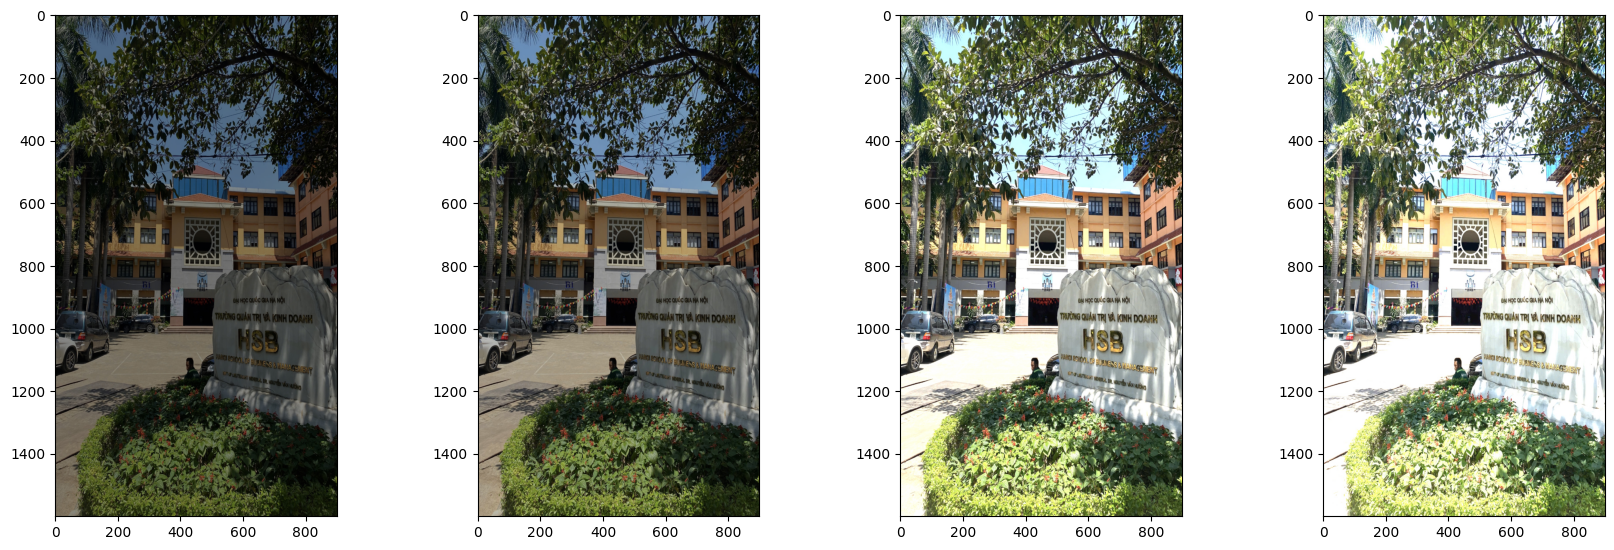

In [114]:
fig=plt.figure(figsize=(20, 10))
columns = len(imgs)
rows = 1
for i in range(1, columns*rows+1):
    img = imgs[i-1]
    fig.subplots_adjust(wspace=0.5)
    fig.add_subplot(rows, columns, i)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)) #Opencv use BGR instead of RGB
    #plt.plot([190],[130], 'bo')
plt.show()

## Compute HDR

In [115]:
#relode module
importlib.reload(hdr)
importlib.reload(align)

<module 'hdrtool.align' from '/Users/bill/Desktop/Projects/high-dynamic-range-imaging/hdrtool/align.py'>

In [116]:
df.exposetime

0     0.25
1     1.00
2     4.00
3    15.00
Name: exposetime, dtype: float64

In [117]:
hdrimg = hdr.computeHDR(imgs, np.log(df.exposetime).astype(np.float32))

channel: 0
    sampling intensities...
    running time: 1.1594460010528564
    computing response curve...
    running time: 0.19150686264038086
    building irradiance map using np...
The length of hdr_image is: 4
Max value in array: 255
    running time: 54.508281230926514
channel: 1
    sampling intensities...
    running time: 1.121541976928711
    computing response curve...
    running time: 0.18889474868774414
    building irradiance map using np...
The length of hdr_image is: 4
Max value in array: 255
    running time: 51.54037594795227
channel: 2
    sampling intensities...
    running time: 1.475848913192749
    computing response curve...
    running time: 0.3566572666168213
    building irradiance map using np...
The length of hdr_image is: 4
Max value in array: 255
    running time: 50.84472417831421


In [118]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as ticker

def plot_radiance(radiance, colors= ['Blue', 'Green', 'Red']):
    print('[Plot] radiance')
    def fmt(x, pos): return '%.3f' % np.exp(x)

    height, width, channels = radiance.shape
    ln_radiance = np.log(radiance)

    plt.clf()
    fig, ax = plt.subplots(1, channels, figsize=(5 * channels, 5))

    for c in range(channels):
        im = ax[c].imshow(ln_radiance[:, :, c], cmap='jet')
        ax[c].set_title(colors[c])
        ax[c].set_axis_off()
        divider = make_axes_locatable(ax[c])
        cax = divider.append_axes("right", size="5%", pad=0.05)
        fig.colorbar(im, cax=cax, format=ticker.FuncFormatter(fmt))

### plotting HDR image

[Plot] radiance


<Figure size 640x480 with 0 Axes>

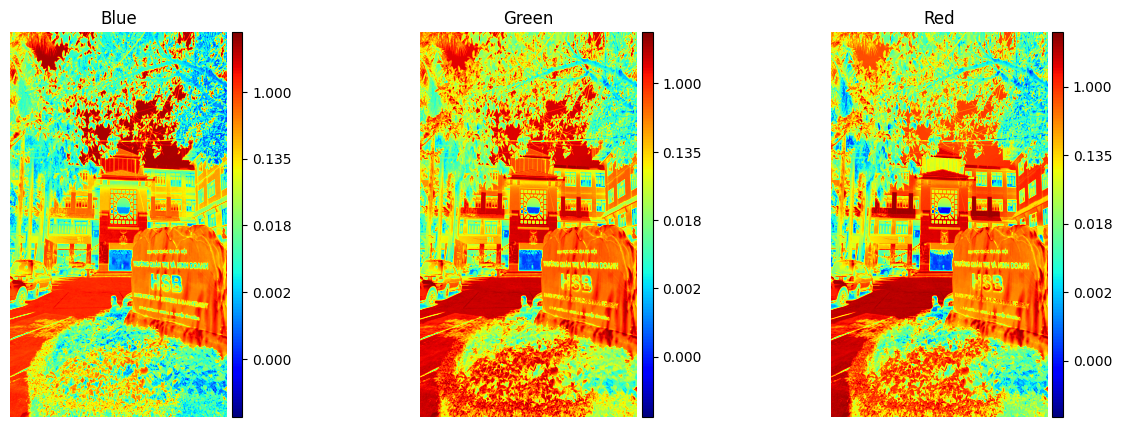

In [119]:
plot_radiance(hdrimg, ['Blue', 'Green', 'Red'])

In [120]:
# save high dynamic range image
cv2.imwrite(HDR_PATH, hdrimg)

True

### Global Tone Mapping and Plotting

#### with lower key

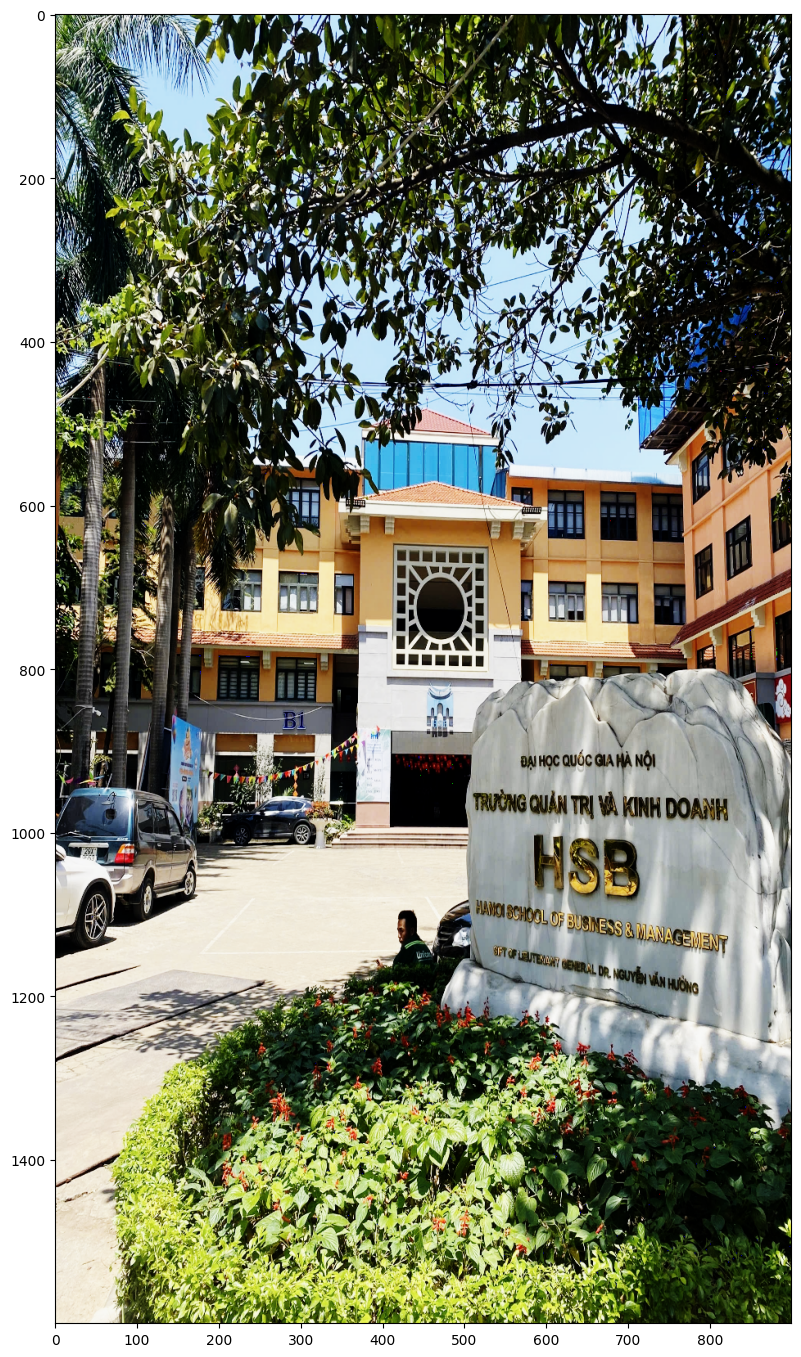

In [121]:
# map hdr image to 0-255
hdr_mapped = hdr.globalToneMapping(hdrimg, Lwhite=np.exp(hdrimg.max())*0.8, alpha=0.4)
cv2.imwrite(OUTPUT_PATH, (hdr_mapped).astype(np.uint8) )
# plotting
plt.figure(figsize=(10, 17))
plt.imshow(cv2.cvtColor((hdr_mapped).astype(np.uint8), cv2.COLOR_BGR2RGB))

#### with higher key

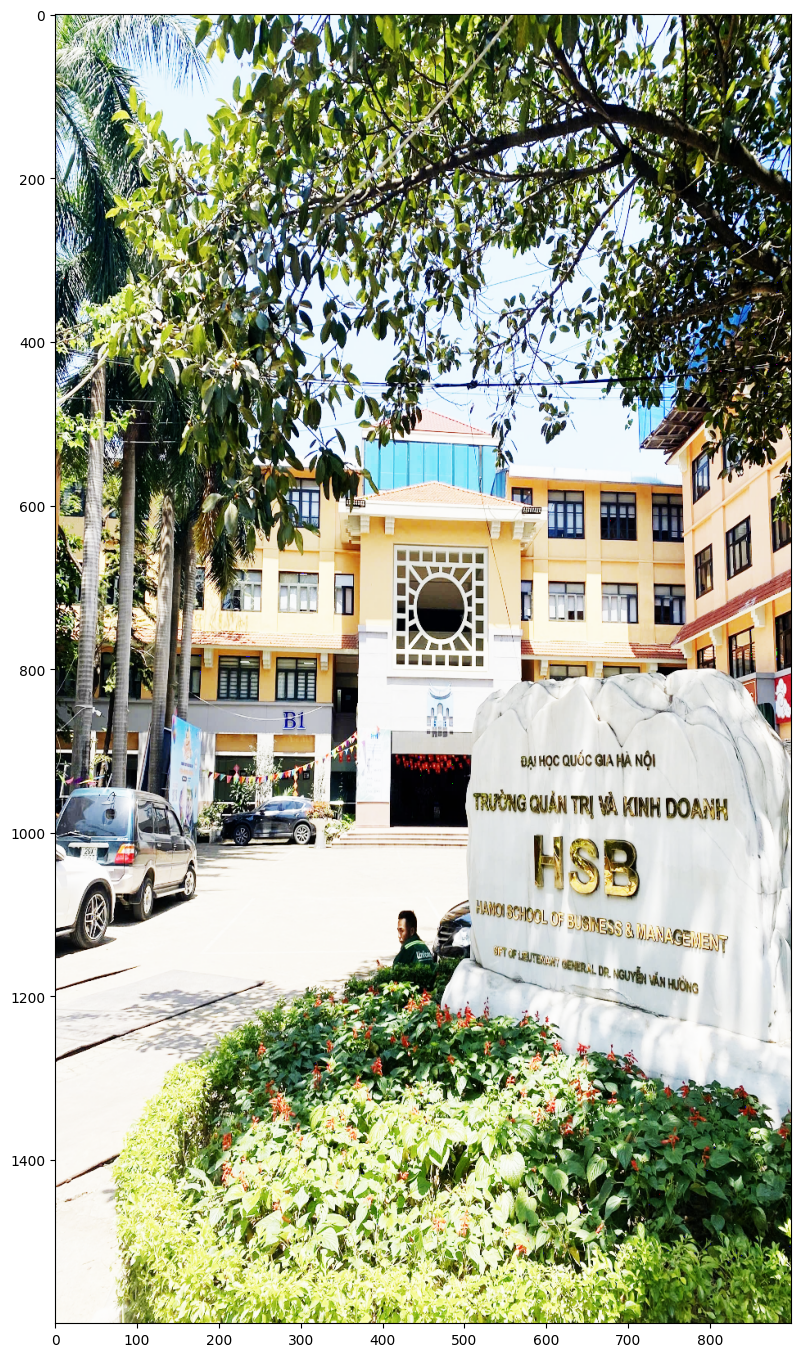

In [122]:
hdr_mapped = hdr.globalToneMapping(hdrimg, Lwhite=np.exp(hdrimg.max())*1.9, alpha=1.8)
cv2.imwrite(OUTPUT_PATH2, (hdr_mapped).astype(np.uint8) )

plt.figure(figsize=(10, 17))
plt.imshow(cv2.cvtColor((hdr_mapped).astype(np.uint8), cv2.COLOR_BGR2RGB))